In [37]:
import pickle as pkl
import pandas as pd
import matplotlib
import os
import re

import collections
import datetime
import time

import geopandas as gpd

import numpy as np

import rasterio

import spacy

import gc

import geopy.distance

nlp = spacy.load('en_core_web_lg')
from sklearn.metrics.pairwise import cosine_similarity

import itertools

import pgeocode

from dateutil.relativedelta import relativedelta

# Indirect
Introduce the SC Data, focusing on transactions between US companies.

In [38]:
c_links = pd.read_csv("../../data/companyData/c_linksUS.csv") # pd.read_csv("../../data/companyData/compustatSCLinked.csv")

c_links['year'] = c_links.srcdate.astype('str').str.slice(0,4).astype('int64')

c_links = c_links[c_links.year > 1999][['year','gvkey','cgvkey','salecs']].\
    rename(columns = {'cgvkey': 'customer_gvkey','gvkey': 'supplier_gvkey'})

c_links['year'] = pd.to_datetime(c_links.year, format = '%Y')


c_links.head()

,year,supplier_gvkey,customer_gvkey,salecs
0,2002-01-01,1013,2136,111.056
1,2004-01-01,1013,2136,104.312
2,2005-01-01,1013,2136,146.000
3,2006-01-01,1013,2136,205.000
4,2007-01-01,1013,2136,236.000


In [39]:
sum(c_links.salecs.isna())

11228

In [40]:
supplierCombos = c_links[['supplier_gvkey', 'customer_gvkey']].drop_duplicates().reset_index(drop = True)

print(supplierCombos.shape)

supplierCombos.head()

(11827, 2)


,supplier_gvkey,customer_gvkey
0,1013,2136
1,1013,9899
2,1021,61494
3,1021,25880
4,1048,11552


We'll follow Barrot Sauvagnat in assuming that a supplier relationship holds for every year between the first and last year in which a customer is reported. This is going to take a little bit of work. We'll try it like this: 
- subset dataframe to a specific supplier-customer pair
- fill in data for every year that's missing

Then, apply this row-wise to all rows of the unique supplierCombos df above using: https://stackoverflow.com/questions/61942138/apply-function-row-wise-to-pandas-dataframe

In [41]:
def fillYear(supplier, customer, scData = c_links):
    c_linksTemp = scData[(scData.supplier_gvkey == supplier) & \
                      (scData.customer_gvkey == customer)].reset_index(drop = True)
    
    # if there are na values and non-na values for the same supplier-cust combination, then 
    # select for only the non-na values, by (1) replacing na with negative, (2) 1
    c_linksTemp['salecs'] = c_linksTemp['salecs'].fillna(-5)
    c_linksTemp = c_linksTemp.loc[c_linksTemp.reset_index().groupby(['year','supplier_gvkey',
                                                                     'customer_gvkey'])['salecs'].idxmax()]
    
    
    # now: find the start and end of the data series
    first = c_linksTemp.year.min() # - relativedelta(years = 1)
    last  = c_linksTemp.year.max() # + relativedelta(years = 1)
    
    
    c_linksTemp['firstYear'] = c_linksTemp.year.min()
    c_linksTemp['lastYear']  = c_linksTemp.year.max()
    
    
    c_linksTemp = c_linksTemp.set_index('year') 
    
    
    c_linksTemp = c_linksTemp.reindex(pd.date_range(first, last, freq = 'YS')).\
        reset_index().rename(columns = {'index': 'year'})
    
    
    # and impute all values within the series
    c_linksTemp = c_linksTemp.groupby(c_linksTemp.year.dt.time).ffill().bfill()
    
    
    return(c_linksTemp)

Show that this works for one of the supplier rows.

In [42]:
fillYear(supplierCombos.supplier_gvkey[0], supplierCombos.customer_gvkey[0])

,year,supplier_gvkey,customer_gvkey,salecs,firstYear,lastYear
0,2002-01-01,1013.0,2136.0,111.056,2002-01-01,2010-01-01
1,2003-01-01,1013.0,2136.0,111.056,2002-01-01,2010-01-01
2,2004-01-01,1013.0,2136.0,104.312,2002-01-01,2010-01-01
3,2005-01-01,1013.0,2136.0,146.000,2002-01-01,2010-01-01
4,2006-01-01,1013.0,2136.0,205.000,2002-01-01,2010-01-01
5,2007-01-01,1013.0,2136.0,236.000,2002-01-01,2010-01-01
6,2008-01-01,1013.0,2136.0,240.000,2002-01-01,2010-01-01
7,2009-01-01,1013.0,2136.0,176.000,2002-01-01,2010-01-01
8,2010-01-01,1013.0,2136.0,146.000,2002-01-01,2010-01-01


Now do it for all rows.

In [43]:
start = time.time()
print(c_links.shape)
c_linksImpd_list = supplierCombos.apply(lambda row: fillYear(row['supplier_gvkey'], row['customer_gvkey']), axis = 1)
c_linksImpd_df   = pd.concat(list(c_linksImpd_list))
print(c_linksImpd_df.shape)
print(time.time() - start)

c_linksImpd_df['year'] = c_linksImpd_df.year.dt.year

(47427, 4)
(49835, 6)
61.00236535072327


We had converted some of the na sales values to -5 so that we could deal with duplicated values, by choosing the larger of said values. Switch back to nan so that we are not thrown off when we look for biggest supplier.

In [44]:
c_linksImpd_df.loc[c_linksImpd_df.salecs == -5, 'salecs'] = float('nan')

In [45]:
industries = pd.read_csv("../../data/companyData/gvkeyIndustries.csv").drop(columns = {'Unnamed: 0'})
print(industries)

       gvkey            indGroup
0       1010                manu
1       1043           wholesale
2       1045  transportUtilities
3       1062             finance
4       1075  transportUtilities
...      ...                 ...
31652  37600             finance
31653  37618             finance
31654  37620             finance
31655  37621             finance
31656  37625             finance

[31657 rows x 2 columns]


In [46]:
c_links = c_linksImpd_df.copy()

print(c_links.shape)

print(c_links.head())

industries.columns = ['customer_gvkey','customer_ind']


c_links = c_links.merge(industries)
industries.columns = ['supplier_gvkey','supplier_ind']

c_links = c_links.merge(industries)
print(c_links.head(), c_links.shape)


c_links.to_csv("../../data/companyData/c_links.csv")


(49835, 6)
   year  supplier_gvkey  customer_gvkey   salecs  firstYear   lastYear
0  2002          1013.0          2136.0  111.056 2002-01-01 2010-01-01
1  2003          1013.0          2136.0  111.056 2002-01-01 2010-01-01
2  2004          1013.0          2136.0  104.312 2002-01-01 2010-01-01
3  2005          1013.0          2136.0  146.000 2002-01-01 2010-01-01
4  2006          1013.0          2136.0  205.000 2002-01-01 2010-01-01
   year  supplier_gvkey  customer_gvkey   salecs  firstYear   lastYear  \
0  2002          1013.0          2136.0  111.056 2002-01-01 2010-01-01   
1  2003          1013.0          2136.0  111.056 2002-01-01 2010-01-01   
2  2004          1013.0          2136.0  104.312 2002-01-01 2010-01-01   
3  2005          1013.0          2136.0  146.000 2002-01-01 2010-01-01   
4  2006          1013.0          2136.0  205.000 2002-01-01 2010-01-01   

         customer_ind supplier_ind  
0  transportUtilities         manu  
1  transportUtilities         manu  
2  tran

Let's see how all this translates into different industries. Check how many times different industries show up.

The full count will be roughly 4x whatever is below, assuming we can get a match for roughly all of them (which we should be able to).

In [47]:
c_links[c_links.year.astype(int) > 1999].supplier_ind.value_counts()

manu                  23886
finance               10474
services               6869
mining                 3451
transportUtilities     2737
wholesale              1348
construction            443
retail                  251
agForFish               105
Name: supplier_ind, dtype: int64

Now see if it's common to have one in and one out of the industries of interest. 

For now, let's keep all the different industry types.

We can always filter later if we need to.


********this is where it would be helpful to check on the abi bits for a given industry, to see if we can get additional matches as well***********

In [48]:
#########################
# get data and reset columns 
gvKey_abiLinkingTable = pd.read_csv('../../data/companyData/sc_linkingTable.csv').drop(columns = ['Unnamed: 0']).\
    drop_duplicates()



base_columns = gvKey_abiLinkingTable.columns 
customer_columns = "customer_" + base_columns
supplier_columns = "supplier_" + base_columns



# merge in customer information
gvKey_abiLinkingTable.columns = customer_columns



print(c_links.shape)
c_linksMerge1 = c_links.merge(gvKey_abiLinkingTable, on ='customer_gvkey')
print(c_links.shape,c_linksMerge1.shape, c_linksMerge1.head())



#########################
# and merge in supplier 
gvKey_abiLinkingTable.columns = supplier_columns

print(c_links.shape)
c_linksMerge2 = c_linksMerge1.merge(gvKey_abiLinkingTable, on ='supplier_gvkey').drop_duplicates()
print(c_linksMerge2.shape)

c_linksMerge2.to_csv("../../data/companyData/clinks_IG_selected.csv")


c_linksMerge2['year'] = pd.to_datetime(c_linksMerge2.year, format = '%Y')


##########################
# get all the company abi
allAbi = c_linksMerge2.customer_abi.append(c_linksMerge2.supplier_abi).drop_duplicates()
allAbi.shape

(49835, 8)
(49835, 8) (47076, 11)    year  supplier_gvkey  customer_gvkey   salecs  firstYear   lastYear  \
0  2002          1013.0          2136.0  111.056 2002-01-01 2010-01-01   
1  2003          1013.0          2136.0  111.056 2002-01-01 2010-01-01   
2  2004          1013.0          2136.0  104.312 2002-01-01 2010-01-01   
3  2005          1013.0          2136.0  146.000 2002-01-01 2010-01-01   
4  2006          1013.0          2136.0  205.000 2002-01-01 2010-01-01   

         customer_ind supplier_ind customer_cstatCompanies  \
0  transportUtilities         manu     verizonmmunications   
1  transportUtilities         manu     verizonmmunications   
2  transportUtilities         manu     verizonmmunications   
3  transportUtilities         manu     verizonmmunications   
4  transportUtilities         manu     verizonmmunications   

  customer_igCompanies  customer_abi  
0  verizonmmunications       7564776  
1  verizonmmunications       7564776  
2  verizonmmunications       75

(4082,)

## Relevant Industries

In [50]:
c_linksMerge2 = c_linksMerge2[(c_linksMerge2.customer_ind != 'services') & (c_linksMerge2.customer_ind != 'finance') & \
               (c_linksMerge2.supplier_ind != 'services') & (c_linksMerge2.supplier_ind != 'finance')]

c_linksMerge2.shape

(26911, 14)

First, make a sample with the companies on one year of either side of when it reports another customer.

In [51]:
########
hqsOnly = pd.read_csv("../../data/ig_uniqueHQs.csv").drop(columns = {'Unnamed: 0'})

hq = pd.read_csv("../../data/ig_uniqueHQs_multLocations.csv").\
    drop(columns = {'Unnamed: 0'}).\
    rename(columns = {'archive_version_year': 'year'})

hq['year']    = pd.to_datetime(hq.year, format = '%Y')   # hq.year.astype('int64')
hq['zipcode'] = hq.zipcode.astype('str').str.zfill(5)
hqRelevant    = hq[hq.abi.isin(allAbi)].reset_index()



I think many of these don't have a lat-long but do have a zipcode. We should be able to use pgeocode to get an approximate lat-long from the zipcode.

In [52]:
us = pgeocode.Nominatim('us')

for i in range(0, hq.shape[0]):
    if pd.isna(hq.latitude[i]):
        hq.latitude[i]  = us.query_postal_code(hq.zipcode[i]).latitude
        hq.longitude[i] = us.query_postal_code(hq.zipcode[i]).longitude

/Users/brianreed/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/brianreed/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [53]:
hq[hq['longitude'].isna()].abi.unique()

array([  1864149,   5136239,   6484067,   7512304,   7536717, 107286601,
       107358178, 120553524, 306744129, 406330118, 406330126, 433385663,
       441433422, 450510896, 477538250, 902151877, 936186998, 967349333,
         7001068, 510200629, 902180348,   4552857,   6918395, 602875296,
       435965967, 657440202, 670508548, 671873610, 207813429, 252925805])

In [54]:
supplierHQ = hq[['year','abi','latitude','longitude','zipcode']].copy().rename(columns = {'abi':      'supplier_abi',
                                                                        'latitude':  'supplier_latitude',
                                                                        'longitude': 'supplier_longitude',
                                                                        'zipcode': 'supplier_zipcode'})


customerHQ = hq[['year','abi','latitude','longitude','zipcode']].copy().rename(columns = {'abi':      'customer_abi',
                                                                        'latitude':  'customer_latitude',
                                                                        'longitude': 'customer_longitude',
                                                                        'zipcode': 'customer_zipcode'})

In [55]:
print(sum(allAbi.isin(supplierHQ.supplier_abi)) ,
     sum(allAbi.isin(customerHQ.customer_abi)))



4059 4059


Merge to the closest year in either direction

In [56]:
merged_dataframe = pd.merge_asof(c_linksMerge2.sort_values('year'), customerHQ.sort_values('year'), on="year",
                                 by="customer_abi", 
                                direction = "nearest")

print(merged_dataframe.shape)
merged_dataframe.head()

(26911, 17)


,year,supplier_gvkey,customer_gvkey,salecs,firstYear,lastYear,customer_ind,supplier_ind,customer_cstatCompanies,customer_igCompanies,customer_abi,supplier_cstatCompanies,supplier_igCompanies,supplier_abi,customer_latitude,customer_longitude,customer_zipcode
0,2000-01-01,21542.0,5680.0,15.498,2000-01-01,2001-01-01,retail,manu,home depot,home depot,7556426,aaon,aaon,882035744,33.86254,-84.48289,30339
1,2000-01-01,4078.0,1240.0,NaN,2000-01-01,2002-01-01,retail,manu,albertson s,albertsons,5995907,dreyer s grand ice crm s,dreyer s grand ice cream s,9556713,43.59764,-116.17884,83726
2,2000-01-01,4078.0,9359.0,NaN,2000-01-01,2002-01-01,retail,manu,safeway,safeway,9606492,dreyer s grand ice crm s,dreyer s grand ice cream s,9556713,37.66144,-121.86914,94566
3,2000-01-01,8336.0,6502.0,1.632,2000-01-01,2000-01-01,retail,manu,kroger,kroger,7521503,paradise,paradise,9096488,39.10673,-84.51422,45202
4,2000-01-01,8336.0,11259.0,3.497,2000-01-01,2018-01-01,retail,manu,walmart,walmart,5889993,paradise,paradise,9096488,36.36072,-94.22725,72712


In [57]:
c_linksMerge3 = pd.merge_asof(merged_dataframe.sort_values('year'), supplierHQ.sort_values('year'), on="year",
                                 by="supplier_abi", 
                                direction = "nearest")

# c_linksMerge2.merge(supplierHQ).merge(customerHQ)


print(c_linksMerge3.shape)


c_linksMerge3 = c_linksMerge3[(~c_linksMerge3.supplier_latitude.isna()) & (~c_linksMerge3.customer_latitude.isna())]

print(c_linksMerge3.shape)

c_linksMerge3 = c_linksMerge3.reset_index(drop = True)

(26911, 20)
(26560, 20)


In [58]:
c_linksMerge3.salecs.sum()/c_linksMerge2.salecs.sum()

0.9899532354715016

Now, find the distances between suppliers.

In [59]:
c_linksMerge3['dist'] = 0

for i in range(0,c_linksMerge3.shape[0]):
    c_linksMerge3.dist[i] = geopy.distance.geodesic((c_linksMerge3.customer_latitude[i],c_linksMerge3.customer_longitude[i]), \
                                                             (c_linksMerge3.supplier_latitude[i],c_linksMerge3.supplier_longitude[i])).km

/Users/brianreed/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


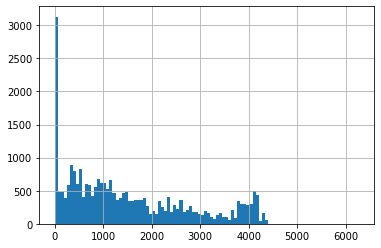

In [60]:
c_linksMerge3.dist.hist(bins = 100)

Try to figure out which companies have no sales figures. Are they the same companies through and through, or are some different ones in play?

This means that most of the firms with an na transaction have another transaction. It could be either that year or another year. If a company has one transaction for a year and it's na, then turn it into a small amount so that we keep it. 

In [61]:
c_linksMerge3['suppliers'] = 1


suppliers = c_linksMerge3[['year', 'customer_gvkey', 'suppliers']].groupby(['year','customer_gvkey']).sum().\
    reset_index().rename(columns = {'suppliers': 'totalSuppliers'})

meanExp   = c_linksMerge3[['year', 'customer_gvkey', 'salecs']].groupby(['year','customer_gvkey'],dropna=False).\
    mean().reset_index().rename(columns = {'salecs': 'meanSales'})

c_linksMerge4 = c_linksMerge3.merge(suppliers).drop(columns = {'suppliers'}).merge(meanExp)



print(c_linksMerge3.shape,c_linksMerge4.shape)


c_linksMerge4.head()

(26560, 22) (26560, 23)


,year,supplier_gvkey,customer_gvkey,salecs,firstYear,lastYear,customer_ind,supplier_ind,customer_cstatCompanies,customer_igCompanies,...,supplier_abi,customer_latitude,customer_longitude,customer_zipcode,supplier_latitude,supplier_longitude,supplier_zipcode,dist,totalSuppliers,meanSales
0,2000-01-01,21542.0,5680.0,15.498,2000-01-01,2001-01-01,retail,manu,home depot,home depot,...,882035744,33.86254,-84.48289,30339,36.12840,-96.01526,74107,1081,22,260.080737
1,2000-01-01,20185.0,5680.0,414.169,2000-01-01,2019-01-01,retail,manu,home depot,home depot,...,434484085,33.86254,-84.48289,30339,39.96110,-83.00094,43215,689,22,260.080737
2,2000-01-01,25536.0,5680.0,28.449,2000-01-01,2019-01-01,retail,wholesale,home depot,home depot,...,414776583,33.86254,-84.48289,30339,37.88911,-122.13040,94549,3405,22,260.080737
3,2000-01-01,1762.0,5680.0,373.200,2000-01-01,2005-01-01,retail,manu,home depot,home depot,...,9055096,33.86254,-84.48289,30339,40.06013,-76.33525,17604,998,22,260.080737
4,2000-01-01,2255.0,5680.0,872.200,2000-01-01,2009-01-01,retail,manu,home depot,home depot,...,7504848,33.86254,-84.48289,30339,39.39956,-76.59114,21286,935,22,260.080737


In [62]:
withNAs = c_linksMerge3[c_linksMerge3.salecs.isna()].customer_gvkey.drop_duplicates()

print("Find the fraction of firms who have an na transaction value one year, but another non-na", 
      withNAs.isin(c_linksMerge4[~c_linksMerge4.salecs.isna()].customer_gvkey.drop_duplicates()).sum()/withNAs.shape)

Find the fraction of firms who have an na transaction value one year, but another non-na [0.7637931]


For each row: if salecs is na, replace with mean sales. If mean sales also na, replace with 1.

In [63]:
for i in range(0,c_linksMerge4.shape[0]):
    
    # if mean sales is na, replace with 1
    if pd.isna(c_linksMerge4.meanSales[i]):
        c_linksMerge4.salecs[i] = 1
    
    # if salecs is na, replace with mean sales
    elif pd.isna(c_linksMerge4.salecs[i]):
        c_linksMerge4.salecs[i] = c_linksMerge4.meanSales[i]

/Users/brianreed/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/brianreed/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [64]:
print(c_linksMerge3[['customer_gvkey', 'year']].drop_duplicates().shape,
     c_linksMerge4[['customer_gvkey', 'year']].drop_duplicates().shape)

(7644, 2) (7644, 2)


In [65]:
c_linksMerge4 = c_linksMerge4[(c_linksMerge4.dist >= 500)]

c_linksMerge4.shape

(19227, 23)

In [75]:
c_linksMerge4.head()

,year,supplier_gvkey,customer_gvkey,salecs,firstYear,lastYear,customer_ind,supplier_ind,customer_cstatCompanies,customer_igCompanies,...,supplier_abi,customer_latitude,customer_longitude,customer_zipcode,supplier_latitude,supplier_longitude,supplier_zipcode,dist,totalSuppliers,meanSales
0,2000-01-01,21542.0,5680.0,15.498,2000-01-01,2001-01-01,retail,manu,home depot,home depot,...,882035744,33.86254,-84.48289,30339,36.12840,-96.01526,74107,1081,22,260.080737
1,2000-01-01,20185.0,5680.0,414.169,2000-01-01,2019-01-01,retail,manu,home depot,home depot,...,434484085,33.86254,-84.48289,30339,39.96110,-83.00094,43215,689,22,260.080737
2,2000-01-01,25536.0,5680.0,28.449,2000-01-01,2019-01-01,retail,wholesale,home depot,home depot,...,414776583,33.86254,-84.48289,30339,37.88911,-122.13040,94549,3405,22,260.080737
3,2000-01-01,1762.0,5680.0,373.200,2000-01-01,2005-01-01,retail,manu,home depot,home depot,...,9055096,33.86254,-84.48289,30339,40.06013,-76.33525,17604,998,22,260.080737
4,2000-01-01,2255.0,5680.0,872.200,2000-01-01,2009-01-01,retail,manu,home depot,home depot,...,7504848,33.86254,-84.48289,30339,39.39956,-76.59114,21286,935,22,260.080737


In [76]:
c_linksMerge4.supplier_zipcode

0        74107
1        43215
2        94549
3        17604
4        21286
         ...  
26554    33760
26555    33408
26557    33408
26558    93012
26559    33760
Name: supplier_zipcode, Length: 19227, dtype: object

## Merge in supplier weather
Get the weather data.

In [77]:
'''g = pd.read_csv("../../data/companyData/weatherByEstablishment.csv").\
    drop(columns = {"Unnamed: 0"})'''


allWeather_withLags = pd.read_csv("../../data/companyData/allWeather_withLags_allZips.csv").\
    drop(columns = {"Unnamed: 0", 'yearQtr'}).astype({'year':       'category',
                           'qtr':        'category',
                           'zipcode':    'category'})


averages = pd.read_csv("../../data/companyData/quarterlyStatsByZip.csv").\
    drop(columns = {"Unnamed: 0"}).rename(columns = {'ZIP': 'zipcode'})
averages['qtr'] = averages.quarter.str.slice(1,2).astype('float')
averages.drop(columns = {'quarter'}, inplace = True) 
averages = averages.astype({'qtr':        'category',
                           'zipcode':    'category'})


allWeather_withLags2 = pd.read_csv("../../data/companyData/allWeather_withLags_new.csv").\
    drop(columns = {"Unnamed: 0", 'yearQtr'}).astype({'year':       'category',
                           'qtr':        'category',
                           'zipcode':    'category'})


thunderstorms_withLags = pd.read_csv("../../data/companyData/thunderstorms_withLags.csv").\
    drop(columns = {"Unnamed: 0", 'yearQtr'}).astype({'year':       'category',
                           'qtr':        'category',
                           'zipcode':    'category'})

In [78]:
allSupplierWeather = allWeather_withLags.merge(averages).\
    merge(thunderstorms_withLags).merge(thunderstorms_withLags).merge(allWeather_withLags2)

# merge(g).streaks_withLags.

for colname in allSupplierWeather.columns[3:]:
    allSupplierWeather.rename(columns = {colname: 'supplier_' + colname}, inplace = True)

allSupplierWeather.rename(columns = {'zipcode': 'supplier_zipcode'}, inplace = True)
allSupplierWeather['supplier_zipcode']     = allSupplierWeather.supplier_zipcode.astype('str').str.zfill(5)

allSupplierWeather.head()

,supplier_zipcode,year,qtr,supplier_precip_annual_50,supplier_precip_annual_95,supplier_precip_annual_99,supplier_precip_zip_50,supplier_precip_zip_95,supplier_precip_zip_99,supplier_precip_zipQuarter_50,...,supplier_lag4_temp_zipQuarter50,supplier_lag4_temp_zipQuarter95,supplier_lag4_precip_zipQuarter50,supplier_lag4_precip_zipQuarter95,supplier_lag4_temp_zipWeek50,supplier_lag4_temp_zipWeek95,supplier_lag4_precip_zipWeek50,supplier_lag4_precip_zipWeek95,supplier_lag4_days90Plus,supplier_lag4_streak90Plus
0,01001,2001,1,12.0,3.0,0.0,35.0,5.0,2.0,35.0,...,1,0,0,0,8,2,8,0,0,0
1,01001,2002,1,13.0,2.0,0.0,34.0,3.0,0.0,34.0,...,0,0,0,0,5,0,7,2,0,0
2,01001,2003,1,13.0,4.0,0.0,34.0,7.0,2.0,34.0,...,1,1,0,0,10,3,6,0,0,0
3,01001,2004,1,8.0,1.0,0.0,34.0,1.0,0.0,34.0,...,0,0,0,0,4,1,6,2,0,0
4,01001,2005,1,20.0,1.0,1.0,35.0,4.0,1.0,35.0,...,0,0,0,0,5,1,4,1,0,0


In [90]:
c_linksMerge4 = c_linksMerge4[c_linksMerge4.supplier_zipcode.isin(allSupplierWeather.supplier_zipcode)]

Now find the largest supplier for each customer.

In [91]:
idx = c_linksMerge4.groupby(['year','customer_gvkey']).salecs.\
    transform(max) == c_linksMerge4.salecs
largestSuppliers_more500k = c_linksMerge4[idx].reset_index(drop = True)
print(c_linksMerge4.shape)

# find companies who only have one other supplier
singleSuppliers_more500k = c_linksMerge4[c_linksMerge4.totalSuppliers == 1].reset_index(drop = True)
print(singleSuppliers_more500k.shape)

# find largest suppliers of different companies
largestSuppliers_more500k = largestSuppliers_more500k.append(singleSuppliers_more500k).drop_duplicates()
print(largestSuppliers_more500k.shape)


(18647, 23)
(2711, 23)
(6988, 23)


In [92]:
largestSuppliers_more500k[['year','customer_gvkey']].drop_duplicates().shape

(6058, 2)

There seem to be a number of ties here, maybe from the companies that had only na values. To get around this, just sample one of each observation by company-group.

In [93]:
randomSample = largestSuppliers_more500k.groupby(['year','customer_gvkey']).\
    apply(lambda x: x.sample(1)).reset_index(drop=True)

In [94]:
randomSample.head()

,year,supplier_gvkey,customer_gvkey,salecs,firstYear,lastYear,customer_ind,supplier_ind,customer_cstatCompanies,customer_igCompanies,...,supplier_abi,customer_latitude,customer_longitude,customer_zipcode,supplier_latitude,supplier_longitude,supplier_zipcode,dist,totalSuppliers,meanSales
0,2000-01-01,112874.0,1013.0,23.366,2000-01-01,2000-01-01,manu,manu,adc telecommunications,adc telecommunications,...,465227874,44.98311,-93.26507,55440,40.02642,-105.22828,80301,1125,2,14.2200
1,2000-01-01,151161.0,1045.0,18.904,2000-01-01,2005-01-01,transportUtilities,manu,american airlines,american airlines,...,173361239,32.88270,-97.03714,75261,34.00618,-118.22375,90058,1970,5,25.6436
2,2000-01-01,24971.0,1078.0,45.927,2000-01-01,2002-01-01,manu,manu,abbott laboratories,abbott laboratories,...,849323969,42.30222,-87.89119,60064,40.27907,-74.55906,08520,1137,5,13.7376
3,2000-01-01,31483.0,1161.0,0.802,2000-01-01,2007-01-01,manu,manu,advanced micro devices,advanced micro devices,...,413606617,37.39239,-122.03870,94088,48.24198,-114.31498,59901,1359,2,0.8020
4,2000-01-01,121718.0,1164.0,121.230,2000-01-01,2001-01-01,transportUtilities,manu,mci,mci,...,970959599,32.32930,-90.33563,39056,37.38971,-122.05239,94043,2939,13,32.8020


In [95]:
allSupplierWeather.year.astype('int').min()

2001

In [96]:
randomSample.shape

(6058, 23)

In [98]:
allSupplierWeather['year'] = allSupplierWeather.year.astype('str').str.slice(0,4).astype('int64')
randomSample['year']       = randomSample.year.astype('str').str.slice(0,4).astype('int64')

Join this in.

In [99]:
compustat = pd.read_csv("../../data/companyData/compustatChanges_withControls.csv").\
    drop(columns = ['Unnamed: 0', 'datadate']).rename(columns = {'gvkey': 'customer_gvkey'})


print(compustat.columns)

Index(['customer_gvkey', 'year', 'qtr', 'companyName', 'curcdq', 'assets',
       'cash', 'costGoodsSold', 'totalInv', 'netIncome', 'opInc_afDep',
       'opInc_befDep', 'totalRevenue', 'costat', 'priceClose', 'add1',
       'addzip', 'city', 'state', 'assetsLast', 'netIncomeLast',
       'totalRevenueLast', 'costGoodsSoldLast', 'totalInvLast',
       'opInc_afDepLast', 'opInc_befDepLast', 'priceCloseLast', 'cashLast',
       'fyearq', 'assetsLagged', 'netIncomeLagged', 'roa_lagged', 'sic2',
       'indGroup', 'earliestYear', 'ageTercile', 'sizeTercile',
       'profitTercile', 'datacqtr', 'datafqtr', 'fyr', 'DATE'],
      dtype='object')


We are losing some observations, but it seems like we're losing them because we don't have calendar quarters aligning with firm quarters.

In [100]:
randomSample.customer_gvkey.isin(compustat.customer_gvkey).sum()/randomSample.shape[0]

0.7896995708154506

In [101]:
randomSample.shape

(6058, 23)

In [102]:
compustat = randomSample.merge(compustat)
print(compustat.shape)


compustat.head()

(17304, 63)


,year,supplier_gvkey,customer_gvkey,salecs,firstYear,lastYear,customer_ind,supplier_ind,customer_cstatCompanies,customer_igCompanies,...,sic2,indGroup,earliestYear,ageTercile,sizeTercile,profitTercile,datacqtr,datafqtr,fyr,DATE
0,2000,151161.0,1045.0,18.904,2000-01-01,2005-01-01,transportUtilities,manu,american airlines,american airlines,...,45,transportUtilities,1963,0,2.0,2.0,2000Q1,2000Q1,12,1970-01-01 00:00:00.020000331
1,2000,151161.0,1045.0,18.904,2000-01-01,2005-01-01,transportUtilities,manu,american airlines,american airlines,...,45,transportUtilities,1963,0,2.0,2.0,2000Q2,2000Q2,12,1970-01-01 00:00:00.020000630
2,2000,151161.0,1045.0,18.904,2000-01-01,2005-01-01,transportUtilities,manu,american airlines,american airlines,...,45,transportUtilities,1963,0,2.0,2.0,2000Q3,2000Q3,12,1970-01-01 00:00:00.020000930
3,2000,151161.0,1045.0,18.904,2000-01-01,2005-01-01,transportUtilities,manu,american airlines,american airlines,...,45,transportUtilities,1963,0,2.0,1.0,2000Q4,2000Q4,12,1970-01-01 00:00:00.020001231
4,2000,24971.0,1078.0,45.927,2000-01-01,2002-01-01,manu,manu,abbott laboratories,abbott laboratories,...,38,manu,1962,0,2.0,2.0,2000Q1,2000Q1,12,1970-01-01 00:00:00.020000331


See what fraction of all samples we would expect to take.

In [103]:
compustat.shape[0]/(randomSample.shape[0]*4)

0.7140970617365467

In [104]:
compustat.shape

(17304, 63)

In [105]:
allSupplierWeather.columns

Index(['supplier_zipcode', 'year', 'qtr', 'supplier_precip_annual_50',
       'supplier_precip_annual_95', 'supplier_precip_annual_99',
       'supplier_precip_zip_50', 'supplier_precip_zip_95',
       'supplier_precip_zip_99', 'supplier_precip_zipQuarter_50',
       ...
       'supplier_lag4_temp_zipQuarter50', 'supplier_lag4_temp_zipQuarter95',
       'supplier_lag4_precip_zipQuarter50',
       'supplier_lag4_precip_zipQuarter95', 'supplier_lag4_temp_zipWeek50',
       'supplier_lag4_temp_zipWeek95', 'supplier_lag4_precip_zipWeek50',
       'supplier_lag4_precip_zipWeek95', 'supplier_lag4_days90Plus',
       'supplier_lag4_streak90Plus'],
      dtype='object', length=164)

In [106]:
largestSuppliersWithWeather = compustat.merge(allSupplierWeather)

In [114]:
largestSuppliersWithWeather.columns[0:100]

Index(['year', 'supplier_gvkey', 'customer_gvkey', 'salecs', 'firstYear',
       'lastYear', 'customer_ind', 'supplier_ind', 'customer_cstatCompanies',
       'customer_igCompanies', 'customer_abi', 'supplier_cstatCompanies',
       'supplier_igCompanies', 'supplier_abi', 'customer_latitude',
       'customer_longitude', 'customer_zipcode', 'supplier_latitude',
       'supplier_longitude', 'supplier_zipcode', 'dist', 'totalSuppliers',
       'meanSales', 'qtr', 'companyName', 'curcdq', 'assets', 'cash',
       'costGoodsSold', 'totalInv', 'netIncome', 'opInc_afDep', 'opInc_befDep',
       'totalRevenue', 'costat', 'priceClose', 'add1', 'addzip', 'city',
       'state', 'assetsLast', 'netIncomeLast', 'totalRevenueLast',
       'costGoodsSoldLast', 'totalInvLast', 'opInc_afDepLast',
       'opInc_befDepLast', 'priceCloseLast', 'cashLast', 'fyearq',
       'assetsLagged', 'netIncomeLagged', 'roa_lagged', 'sic2', 'indGroup',
       'earliestYear', 'ageTercile', 'sizeTercile', 'profitTercil

Now put in the customer hq thing, so we can filter out customer-supplier pairs that are within x miles of each other.

In [107]:
largestSuppliersWithWeather.rename(columns = {'customer_gvkey': 'gvkey'}, inplace = True)

In [108]:
largestSuppliersWithWeather.to_csv("../../data/companyData/largestSuppliersWithWeather_more500K.csv")

In [110]:
largestSuppliersWithWeather.shape

(16517, 224)

In [109]:
largestSuppliersWithWeather.head()

,year,supplier_gvkey,gvkey,salecs,firstYear,lastYear,customer_ind,supplier_ind,customer_cstatCompanies,customer_igCompanies,...,supplier_lag4_temp_zipQuarter50,supplier_lag4_temp_zipQuarter95,supplier_lag4_precip_zipQuarter50,supplier_lag4_precip_zipQuarter95,supplier_lag4_temp_zipWeek50,supplier_lag4_temp_zipWeek95,supplier_lag4_precip_zipWeek50,supplier_lag4_precip_zipWeek95,supplier_lag4_days90Plus,supplier_lag4_streak90Plus
0,2001,151161.0,1045.0,16.216,2000-01-01,2005-01-01,transportUtilities,manu,american airlines,american airlines,...,0,0,1,0,6,1,6,0,0,0
1,2001,151161.0,1045.0,16.216,2000-01-01,2005-01-01,transportUtilities,manu,american airlines,american airlines,...,1,0,1,0,11,1,3,2,1,0
2,2001,151161.0,1045.0,16.216,2000-01-01,2005-01-01,transportUtilities,manu,american airlines,american airlines,...,0,0,1,0,7,0,2,1,9,0
3,2001,151161.0,1045.0,16.216,2000-01-01,2005-01-01,transportUtilities,manu,american airlines,american airlines,...,0,0,0,0,5,0,3,1,0,0
4,2001,24971.0,1078.0,49.600,2000-01-01,2002-01-01,manu,manu,abbott laboratories,abbott laboratories,...,1,0,0,0,9,3,6,0,0,0


In [65]:
for col in largestSuppliersWithWeather.columns:
    print(col)

year
supplier_gvkey
gvkey
salecs
firstYear
lastYear
customer_ind
supplier_ind
customer_cstatCompanies
customer_igCompanies
customer_abi
supplier_cstatCompanies
supplier_igCompanies
supplier_abi
customer_latitude
customer_longitude
customer_zipcode
supplier_latitude
supplier_longitude
supplier_zipcode
dist
totalSuppliers
meanSales
qtr
companyName
curcdq
assets
cash
costGoodsSold
totalInv
netIncome
opInc_afDep
opInc_befDep
totalRevenue
costat
priceClose
add1
addzip
city
state
assetsLast
netIncomeLast
totalRevenueLast
costGoodsSoldLast
totalInvLast
opInc_afDepLast
opInc_befDepLast
priceCloseLast
cashLast
fyearq
assetsLagged
netIncomeLagged
roa_lagged
sic2
indGroup
earliestYear
ageTercile
sizeTercile
profitTercile
datacqtr
datafqtr
fyr
DATE
supplier_precip_annual_50
supplier_precip_annual_95
supplier_precip_annual_99
supplier_precip_zip_50
supplier_precip_zip_95
supplier_precip_zip_99
supplier_precip_zipQuarter_50
supplier_precip_zipQuarter_95
supplier_precip_zipQuarter_99
supplier_temp_an

## Sales-Weighted Average
If a company doesn't have sales-specific information, then assume equal shares. This doesn't happen for too many of the companies, thankfully.

In [ ]:
customerDB = c_links[['year','customer_gvkey','supplier_gvkey','salecs']].\
    merge(custExp).rename(columns = {'customer_gvkey': 'gvkey'}).drop_duplicates()

customerDB['salesWeight'] = customerDB.salecs/customerDB.totalExp

customerDB.fillna(1, inplace = True)

Now merge this with the supplier weather data, and use the sales weights to find a sales-weighted average of the weather conditions for the suppliers.

In [ ]:
relevantVars = [x for x in suppliersWithWeather.columns if (('year' in x) | 
                                                 ('qtr' in x) |
                                                 ('gvkey' in x) |
                                                 ('_' in x)) & 
                                                ~('roa_lagged' in x) & 
                                                ~('yearQtr' in x)]

suppliers_toMerge = suppliersWithWeather[relevantVars]


for colname in suppliers_toMerge.columns[3:]:
    suppliers_toMerge.rename(columns = {colname: 'supplier_' + colname}, inplace = True)

    
suppliers_toMerge.rename(columns = {'gvkey': 'supplier_gvkey'},inplace = True)    


In [ ]:
suppliers_toMerge.head()

For each of the supplier weather columns, multiply the variable by the fraction of sales attributable to that relationship.

In [ ]:
supplierWeather = customerDB[['year','gvkey','supplier_gvkey','salesWeight']].merge(suppliers_toMerge)

for col in supplierWeather.columns[7:]:
        supplierWeather[col]   = supplierWeather.salesWeight*supplierWeather[col]
        
        

supplierWeather.drop(columns = {'supplier_gvkey','salesWeight'}, inplace = True)


print(supplierWeather.head())



# [['year','qtr','gvkey','supplier_tmax_quant_1.0','supplier_precip_quant_1.0']]

In [ ]:
supplierWtdAvgWeather = supplierWeather.groupby(['year','qtr','gvkey']).sum().reset_index().drop_duplicates()

In [ ]:
supplierWtdAvgWeather.gvkey.unique()

Merge the supplier weighted average weather data with the customer data that has weather as well.

In [ ]:
customersWithWeather.head()

In [ ]:
wtdAvgSuppliers = customersWithWeather.merge(supplierWtdAvgWeather)

wtdAvgSuppliers.head()

In [ ]:
wtdAvgSuppliers.shape

In [ ]:
wtdAvgSuppliers.to_csv("../../data/companyData/wtdAvgSuppliers.csv")

In [ ]:
wtdAvgSuppliers.head()

In [ ]:
wtdAvgSuppliers.columns[wtdAvgSuppliers.columns.str.contains('Tercile')]